In [35]:
import os
imdb_dir = '/Users/kudelin/Downloads/aclImdb' 
train_dir = os.path.join(imdb_dir, 'train')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type) 
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname)) 
            texts.append(f.read())
            f.close()
        if label_type == 'neg':
            labels.append(0) 
        else:
            labels.append(1)

In [36]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np


In [37]:
maxlen = 1000
training_samples = 2000
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words) 
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [38]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index)) 

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)

print('Shape of data tensor:', data.shape) 
print('Shape of label tensor:', labels.shape)

Found 88582 unique tokens.
Shape of data tensor: (25000, 1000)
Shape of label tensor: (25000,)


In [39]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [40]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]


In [41]:
glove_dir = '/Users/kudelin/Downloads/glove.6B'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt')) 
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32') 
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [42]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim)) 
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word) 
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [43]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen)) 
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 1000, 100)         1000000   
_________________________________________________________________
flatten_7 (Flatten)          (None, 100000)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                3200032   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 4,200,065
Trainable params: 4,200,065
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


In [45]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')


Train on 2000 samples, validate on 10000 samples
Epoch 1/10
2000/2000 [==============================] - 3s 2ms/step - loss: 1.1631 - acc: 0.5625 - val_loss: 0.7780 - val_acc: 0.5157
Epoch 2/10
2000/2000 [==============================] - 3s 2ms/step - loss: 0.5879 - acc: 0.7145 - val_loss: 0.7279 - val_acc: 0.5961
Epoch 3/10
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3745 - acc: 0.8320 - val_loss: 0.6870 - val_acc: 0.6145
Epoch 4/10
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2613 - acc: 0.9045 - val_loss: 0.6699 - val_acc: 0.6535
Epoch 5/10
2000/2000 [==============================] - 3s 2ms/step - loss: 0.1715 - acc: 0.9455 - val_loss: 0.7025 - val_acc: 0.6476
Epoch 6/10
2000/2000 [==============================] - 3s 2ms/step - loss: 0.1090 - acc: 0.9715 - val_loss: 0.8014 - val_acc: 0.6452
Epoch 7/10
2000/2000 [==============================] - 3s 2ms/step - loss: 0.0628 - acc: 0.9845 - val_loss: 1.9499 - val_acc: 0.5219
Epoch 8/10
20

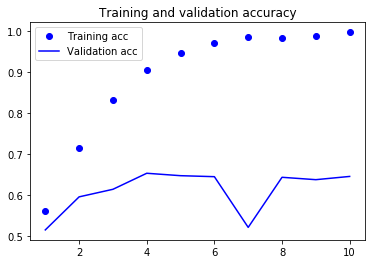

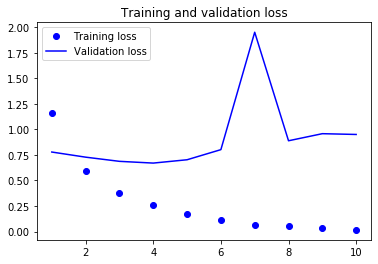

In [46]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [49]:
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type) 
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
        if label_type == 'neg':
            labels.append(0) 
        else:
            labels.append(1)
            
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)


In [51]:
model.load_weights('pre_trained_glove_model.h5') 
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 3s 114us/step


[0.9524996329450607, 0.6384000182151794]